# Requirements

In [222]:
%pip install pandas openpyxl plotly nbformat scipy statsmodels ipywidgets matplotlib seaborn sklearn

Note: you may need to restart the kernel to use updated packages.


# Data Preprocessing

In [223]:
import pandas as pd
import numpy as np

df = pd.read_excel('social_data.xlsx')

In [224]:
df.head(10)

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type
0,2023-03-31 19:55:43.192,CSGO,TWITTER,N/A,0,0,Text
1,2023-03-31 19:49:35.243,CSGO,TWITTER,N/A,0,0,Text
2,2023-03-31 19:49:33.535,CSGO,TWITTER,N/A,0,0,Text
3,2023-03-31 19:49:31.583,CSGO,TWITTER,N/A,0,0,Text
4,2023-03-31 19:43:42.590,CSGO,TWITTER,Community Engagement,9517,1215,Video
5,2023-03-31 19:42:11.331,CSGO,TWITTER,N/A,0,0,Photo
6,2023-03-31 19:40:57.383,CSGO,TWITTER,Community Engagement,1882,83,Photo
7,2023-03-31 19:23:57.349,CSGO,TWITTER,Community Engagement,17892,3076,Video
8,2023-03-31 19:15:14.431,CSGO,TWITTER,N/A,0,0,Video
9,2023-03-31 18:55:51.855,CSGO,TWITTER,Community Engagement,13874,1447,Video


In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Published Date     3479 non-null   datetime64[ns]
 1   Account            3479 non-null   object        
 2   Account Type       3479 non-null   object        
 3   Campaign Name      3479 non-null   object        
 4   Total Impressions  3479 non-null   int64         
 5   Total Engagements  3479 non-null   int64         
 6   Media Type         3479 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 190.4+ KB


In [226]:
# check if object columns need cleaning

# account
df['Account'].unique()

# account has some extra spaces for value 'General'
df['Account'] = df['Account'].str.strip()

In [227]:
# Account Type
df['Account Type'].unique()

array(['TWITTER', 'FBPAGE', 'INSTAGRAM', 'TIKTOK_BUSINESS', 'YOUTUBE',
       'LINKEDIN_COMPANY'], dtype=object)

In [228]:
# Campaign Name
df['Campaign Name'].unique()

# Campaign Name has some extra spaces
df['Campaign Name'] = df['Campaign Name'].str.strip()

In [229]:
# Media Type
df['Media Type'].unique()

array(['Text', 'Video', 'Photo', 'Link', 'Carousel', 'Mixed', 'Album'],
      dtype=object)

In [230]:
# check if there are any rows where engagement is more than impressions
df[df['Total Engagements'] > df['Total Impressions']]

# drop rows where engagement is more than impressions
df = pd.DataFrame(df[df['Total Engagements'] <= df['Total Impressions']])

In [231]:
ENGAGEMENT_RATE = 'Engagement Rate'
NUMBER_OF_POSTS = 'Number of Posts'
WEIGHTED_RATE = 'Engagement Rate per Post'
PUBLISHED_DATE = 'Published Date'

df[ENGAGEMENT_RATE] = df['Total Engagements'] / df['Total Impressions'] * 100
df[ENGAGEMENT_RATE].fillna(0, inplace=True)
df[ENGAGEMENT_RATE] = df[ENGAGEMENT_RATE].round(2)

In [232]:
df.describe()

,Published Date,Total Impressions,Total Engagements,Engagement Rate
count,3476,3476.000000,3476.000000,3476.000000
mean,2023-02-20 00:09:29.971810816,10981.835443,946.838895,4.202652
min,2023-01-01 14:59:04,0.000000,0.000000,0.000000
25%,2023-01-31 17:48:14.750000128,167.750000,0.000000,0.000000
50%,2023-02-18 13:18:17.935000064,1887.000000,38.000000,2.040000
75%,2023-03-09 17:23:37.171000064,12469.000000,276.000000,5.000000
max,2023-03-31 19:55:43.192000,753227.000000,95062.000000,100.000000
std,NaN,29588.146774,3469.759306,6.736225


In [233]:
# plot the KDE of engagement rate
import plotly.express as px

fig = px.histogram(df, x=ENGAGEMENT_RATE, nbins=100, marginal='box')
fig.show()

In [234]:
# detect and remove outliers using IQR
Q1 = df[ENGAGEMENT_RATE].quantile(0.25)
Q3 = df[ENGAGEMENT_RATE].quantile(0.75)
IQR = Q3 - Q1

# create a copy of the original dataframe
df_all = df.copy()

# save the outliers in a separate dataframe
outliers = df[((df[ENGAGEMENT_RATE] < (Q1 - 1.5 * IQR)) | (df[ENGAGEMENT_RATE] > (Q3 + 1.5 * IQR)))]

# remove the outliers from the original dataframe
df = pd.DataFrame(df[~((df[ENGAGEMENT_RATE] < (Q1 - 1.5 * IQR)) | (df[ENGAGEMENT_RATE] > (Q3 + 1.5 * IQR)))])

# What is the typical engagement rate we can expect? What's the likelihood that we can achieve a 15% engagement rate?

In [235]:
print('Typical engagement rate to be expected for any kind of post: {0}%'.format(df[ENGAGEMENT_RATE].mean().round(2)))
print('Median engagement rate is: {0}%'.format(df[ENGAGEMENT_RATE].median().round(2)))

Typical engagement rate to be expected for any kind of post: 2.58%
Median engagement rate is: 1.72%


In [236]:
# find the likelihood of achieving an engagement rate of 15% or more
print('Likelihood of achieving an engagement rate of 15% or more: {0}%'.format(
    df[df[ENGAGEMENT_RATE] >= 15][ENGAGEMENT_RATE].count() / df[ENGAGEMENT_RATE].count() * 100))

print('Likelihood of achieving an engagement rate of 15% or more (considering outliers): {0:.2f}%'.format(outliers[outliers[ENGAGEMENT_RATE] >= 15][ENGAGEMENT_RATE].count() / (outliers[ENGAGEMENT_RATE].count() + df[ENGAGEMENT_RATE].count()) * 100))

Likelihood of achieving an engagement rate of 15% or more: 0.0%
Likelihood of achieving an engagement rate of 15% or more (considering outliers): 6.42%


# Does day of the week and time of posting affect engagement rates?

In [237]:
# create a groupby object by grouping the data by the 'Date' column using the weekday of the date
day_group = df.groupby(df[PUBLISHED_DATE].dt.weekday)

# create a new dataframe with the mean engagement rate for each day of the week
day_df = pd.DataFrame(day_group[ENGAGEMENT_RATE].mean())
day_df['Day'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df[NUMBER_OF_POSTS] = day_group[ENGAGEMENT_RATE].count()
day_df[WEIGHTED_RATE] = day_df[ENGAGEMENT_RATE] / day_df[NUMBER_OF_POSTS]
day_df.set_index('Day', inplace=True)

# normalize the weighted engagement rate
day_df[WEIGHTED_RATE] = day_df[WEIGHTED_RATE] / day_df[WEIGHTED_RATE].max() * 100

In [238]:
day_df

,Engagement Rate,Number of Posts,Engagement Rate per Post
Day,,,
Monday,2.474273,220,100.000000
Tuesday,2.731914,491,49.472142
Wednesday,2.363291,547,38.415362
Thursday,2.751106,633,38.643700
Friday,2.799356,652,38.175578
Saturday,2.293980,304,67.095162
Sunday,2.260089,337,59.630817


In [239]:
# create a groupby object by grouping the data by the 'Date' column using the hour of the date
hour_group = df.groupby(df[PUBLISHED_DATE].dt.hour)

# create a new dataframe with the mean engagement rate for each hour of the day
hour_df = pd.DataFrame(hour_group[ENGAGEMENT_RATE].mean())
hour_df['Hour'] = hour_df.index
hour_df[NUMBER_OF_POSTS] = hour_group[ENGAGEMENT_RATE].count()
hour_df[WEIGHTED_RATE] = hour_df[ENGAGEMENT_RATE] / hour_df[NUMBER_OF_POSTS]
hour_df.set_index('Hour', inplace=True)

# normalize the weighted engagement rate
hour_df[WEIGHTED_RATE] = hour_df[WEIGHTED_RATE] / hour_df[WEIGHTED_RATE].max() * 100

In [240]:
hour_df

,Engagement Rate,Number of Posts,Engagement Rate per Post
Hour,,,
0,0.000000,1,0.000000
2,0.840000,1,100.000000
3,3.980000,5,94.761905
4,3.280000,8,48.809524
5,3.662308,26,16.768808
6,2.915846,65,5.340378
7,3.394000,115,3.513458
8,3.233581,148,2.601014
9,2.662118,340,0.932114


In [241]:
# create a plotly bar chart of the mean engagement rate for each day of the week
import plotly.express as px
import plotly.io as pio

pio.templates.default = 'plotly_dark'
COLOR = 'Sunset_r'

fig = px.bar(day_df, x=day_df.index, y=ENGAGEMENT_RATE, color=NUMBER_OF_POSTS, color_continuous_scale=COLOR)
fig.update_layout(title='Mean Engagement Rate by Day of the Week', xaxis_title='Day of the Week', yaxis_title='Mean Engagement Rate (%)')
fig.show()

# create a plotly bar chart of the mean engagement rate for each hour of the day
fig = px.bar(hour_df, x=hour_df.index, y=ENGAGEMENT_RATE, color=NUMBER_OF_POSTS, color_continuous_scale=COLOR)
fig.update_layout(title='Mean Engagement Rate by Hour of the Day', xaxis_title='Hour of the Day', yaxis_title='Mean Engagement Rate (%)')
fig.show()

In [242]:
# create a groupby object by grouping the data based on weekday for the outlier dataframe
outlier_day_group = outliers.groupby(outliers[PUBLISHED_DATE].dt.weekday)

# create a new dataframe with the mean engagement rate for each day of the week and the number of posts
outlier_day_df = pd.DataFrame(outlier_day_group[ENGAGEMENT_RATE].mean())
outlier_day_df['Day'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
outlier_day_df[NUMBER_OF_POSTS] = outlier_day_group[ENGAGEMENT_RATE].count()

# create a bar chart of number of posts for each day of the week with engagement rate as the color
fig = px.bar(outlier_day_df, x='Day', y=NUMBER_OF_POSTS, color=ENGAGEMENT_RATE, color_continuous_scale=COLOR)
fig.update_layout(title='Number of Exceptional (Outlier) Posts by Day of the Week', xaxis_title='Day of the Week', yaxis_title=NUMBER_OF_POSTS)
fig.show()

In [243]:
# create a groupby object by grouping the data based on hour for the outlier dataframe
outlier_hour_group = outliers.groupby(outliers[PUBLISHED_DATE].dt.hour)

# create a new dataframe with the mean engagement rate for each day of the week and the number of posts
outlier_hour_df = pd.DataFrame(outlier_hour_group[ENGAGEMENT_RATE].mean())
outlier_hour_df['Hour'] = outlier_hour_df.index
outlier_hour_df[NUMBER_OF_POSTS] = outlier_hour_group[ENGAGEMENT_RATE].count()
outlier_hour_df.set_index('Hour', inplace=True)

# create a bar chart of number of posts for each day of the week with engagement rate as the color
fig = px.bar(outlier_hour_df, x=outlier_hour_df.index, y=NUMBER_OF_POSTS, color=ENGAGEMENT_RATE, color_continuous_scale=COLOR)
fig.update_layout(title='Number of Exceptional (Outlier) Posts by Hour of the day', xaxis_title='Hour of the Day', yaxis_title=NUMBER_OF_POSTS)
fig.show()

## Statistical tests to identify if any relationship exists between day of the week and engagement

In [244]:
# statistical test to check if there is a significant difference in the mean engagement rate for each day of the week
from scipy.stats import f_oneway

# create a list of the mean engagement rate for each day of the week
monday = df[df[PUBLISHED_DATE].dt.weekday == 0][ENGAGEMENT_RATE]
tuesday = df[df[PUBLISHED_DATE].dt.weekday == 1][ENGAGEMENT_RATE]
wednesday = df[df[PUBLISHED_DATE].dt.weekday == 2][ENGAGEMENT_RATE]
thursday = df[df[PUBLISHED_DATE].dt.weekday == 3][ENGAGEMENT_RATE]
friday = df[df[PUBLISHED_DATE].dt.weekday == 4][ENGAGEMENT_RATE]
saturday = df[df[PUBLISHED_DATE].dt.weekday == 5][ENGAGEMENT_RATE]
sunday = df[df[PUBLISHED_DATE].dt.weekday == 6][ENGAGEMENT_RATE]

# perform the statistical test
anova_result = f_oneway(monday, tuesday, wednesday, thursday, friday, saturday, sunday)

# check if null hypothesis is rejected at 5% significance level
if anova_result[1] < 0.05:
    print('Null hypothesis rejected. There is a significant difference in the mean engagement rate for each day of the week.')


Null hypothesis rejected. There is a significant difference in the mean engagement rate for each day of the week.


In [245]:
# conduct a statistical test to find out which days of the week have a significantly higher mean engagement rate than the other days
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# perform the statistical test
tukey_result = pairwise_tukeyhsd(df[ENGAGEMENT_RATE], df[PUBLISHED_DATE].dt.weekday, 0.05)

# print the result of the test
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.2576 0.9226 -0.4218 0.9371  False
     0      2   -0.111  0.999 -0.7796 0.5576  False
     0      3   0.2768  0.876 -0.3786 0.9323  False
     0      4   0.3251 0.7635 -0.3279 0.9781  False
     0      5  -0.1803 0.9916 -0.9216  0.561  False
     0      6  -0.2142 0.9769 -0.9401 0.5117  False
     1      2  -0.3686 0.3595 -0.8893  0.152  False
     1      3   0.0192    1.0 -0.4844 0.5228  False
     1      4   0.0674 0.9997  -0.433 0.5679  False
     1      5  -0.4379 0.3445 -1.0491 0.1733  False
     1      6  -0.4718 0.2208 -1.0642 0.1206  False
     2      3   0.3878 0.2251 -0.1011 0.8767  False
     2      4   0.4361 0.1119 -0.0495 0.9216  False
     2      5  -0.0693 0.9999 -0.6684 0.5298  False
     2      6  -0.1032 0.9985 -0.6832 0.4767  False
     3      4   0.0482 0.9999 -0.4191 0.5156  False
     3      

Statistical tests conducted signify that there is no significant difference in the engagement rates based on the day of posting

## Statistical test to identify if hour of posting affects engagement rates

In [246]:
# conduct a statistical test to check if there is a significant difference in the mean engagement rate for each hour of the day
from scipy.stats import f_oneway

# create a dictionary of the mean engagement rate for each hour of the day using for loop
hour_list = {}
for i in range(24):
    hour_list[i] = df[df[PUBLISHED_DATE].dt.hour == i][ENGAGEMENT_RATE]

# print the hours with no posts
print('Hours with no posts:')
for key, value in hour_list.items():
    if len(value) == 0:
        print(key)

# convert the dictionary to a list and remove the hours with no posts
hour_list = list(hour_list.values())
hour_list = [x for x in hour_list if len(x) != 0]

# perform the statistical test
anova_result = f_oneway(*hour_list)

# check if null hypothesis is rejected at 5% significance level
if anova_result[1] < 0.05:
    print('Null hypothesis rejected. There is a significant difference in the mean engagement rate for each hour of the day.')

Hours with no posts:
1
Null hypothesis rejected. There is a significant difference in the mean engagement rate for each hour of the day.


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      2     0.84    1.0 -13.6564 15.3364  False
     0      3     3.98 0.9998  -7.2489 15.2089  False
     0      4     3.28    1.0  -7.5923 14.1523  False
     0      5   3.6623 0.9999  -6.7835 14.1081  False
     0      6   2.9158    1.0  -7.4132 13.2449  False
     0      7    3.394 0.9999   -6.901  13.689  False
     0      8   3.2336    1.0  -7.0515 13.5187  False
     0      9   2.6621    1.0  -7.6035 12.9277  False
     0     10   2.6311    1.0  -7.6398  12.902  False
     0     11   2.3827    1.0  -7.8824 12.6477  False
     0     12   2.4699    1.0  -7.7984 12.7383  False
     0     13   2.1762    1.0  -8.0909 12.4434  False
     0     14   2.4819    1.0  -7.7842  12.748  False
     0     15    2.685    1.0  -7.5822 12.9522  False
     0     16   2.5041    1.0  -7.7655 12.7737  False
     0     17   2.6909    1.

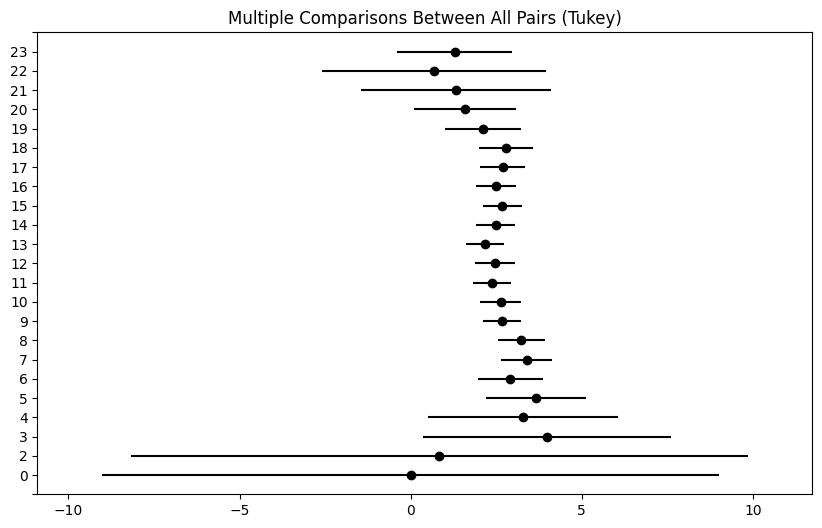

Hours with a significantly higher mean engagement rate than the other hours:
     group1  group2  meandiff   p-adj   lower   upper  reject
122       7      13   -1.2178  0.0164 -2.3380 -0.0976    True
137       8      13   -1.0573  0.0341 -2.0826 -0.0321    True


In [247]:
# perform a statistical test to find out which hours of the day have a significantly higher mean engagement rate than the other hours
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

# perform the statistical test
tukey_result = pairwise_tukeyhsd(df[ENGAGEMENT_RATE], df[PUBLISHED_DATE].dt.hour, 0.05)

# from the result of the test above, find out which hours of the day have a significantly higher mean engagement rate than the other hours
tukey_result.plot_simultaneous()
plt.show()

print('Hours with a significantly higher mean engagement rate than the other hours:')
# convert the result of the test to a dataframe
tukey_result_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
print(tukey_result_df[tukey_result_df['reject'] == True])

In [288]:
# create a groupby object by grouping the data first by hour of the day and then by day of the week
hour_day_group = df.groupby([df[PUBLISHED_DATE].dt.hour, df[PUBLISHED_DATE].dt.weekday])

# create a new dataframe with the mean engagement rate for each hour of the day and day of the week
hour_day_df = pd.DataFrame(hour_day_group[ENGAGEMENT_RATE].mean())
hour_day_df['Hour'] = hour_day_df.index.get_level_values(0)
hour_day_df['Day'] = hour_day_df.index.get_level_values(1)
hour_day_df.reset_index(drop=True, inplace=True)

# sort the dataframe by hour of the day and day of the week
hour_day_df.sort_values(['Hour', 'Day'], inplace=True)

# change weekday numbers to weekday names
hour_day_df['Day'] = hour_day_df['Day'].replace([0, 1, 2, 3, 4, 5, 6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# add number of posts to the dataframe
hour_day_df[NUMBER_OF_POSTS] = hour_day_group[ENGAGEMENT_RATE].count().values



In [289]:
hour_day_df

,Engagement Rate,Hour,Day,Number of Posts
0,0.000000,0,Friday,1
1,0.840000,2,Tuesday,1
2,3.590000,3,Wednesday,1
3,1.880000,3,Thursday,1
4,7.920000,3,Friday,1
...,...,...,...,...
124,3.110000,22,Friday,1
125,0.000000,22,Saturday,2
126,0.185714,23,Tuesday,7
127,6.250000,23,Wednesday,1


In [290]:
# plot 7 graphs of the mean engagement rate for each hour of the day, one for each day of the week

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day in days:
    fig = px.bar(hour_day_df[hour_day_df['Day'] == day], x='Hour', y=ENGAGEMENT_RATE, color=NUMBER_OF_POSTS, color_continuous_scale=COLOR)
    fig.update_layout(title='Mean Engagement Rate by Hour of the Day on {0}'.format(day), xaxis_title='Hour of the Day', yaxis_title='Mean Engagement Rate (%)', yaxis_range=[0, 10], xaxis_range=[0,24])
    fig.show()

In [291]:
# conduct 7 statistical tests to find out if there is a significant difference in the mean engagement rate for each hour of the day for each day of the week
from scipy.stats import f_oneway

# perform 7 one-way ANOVA tests
for day in days:
    hour_list = {}
    for i in range(24):
        hour_list[i] = df[df[PUBLISHED_DATE].dt.hour == i][ENGAGEMENT_RATE]

    # print the hours with no posts
    print('Hours with no posts on {0}:'.format(day))
    for key, value in hour_list.items():
        if len(value) == 0:
            print(key)

    # convert the dictionary to a list and remove the hours with no posts
    hour_list = list(hour_list.values())
    hour_list = [x for x in hour_list if len(x) != 0]
    
    anova_result = f_oneway(*hour_list)
    if anova_result[1] < 0.05:
        print('Null hypothesis rejected. There is a significant difference in the mean engagement rate for each hour of the day on {0}.'.format(day))


Hours with no posts on Monday:
1
Null hypothesis rejected. There is a significant difference in the mean engagement rate for each hour of the day on Monday.
Hours with no posts on Tuesday:
1
Null hypothesis rejected. There is a significant difference in the mean engagement rate for each hour of the day on Tuesday.
Hours with no posts on Wednesday:
1
Null hypothesis rejected. There is a significant difference in the mean engagement rate for each hour of the day on Wednesday.
Hours with no posts on Thursday:
1
Null hypothesis rejected. There is a significant difference in the mean engagement rate for each hour of the day on Thursday.
Hours with no posts on Friday:
1
Null hypothesis rejected. There is a significant difference in the mean engagement rate for each hour of the day on Friday.
Hours with no posts on Saturday:
1
Null hypothesis rejected. There is a significant difference in the mean engagement rate for each hour of the day on Saturday.
Hours with no posts on Sunday:
1
Null hypo

Monday


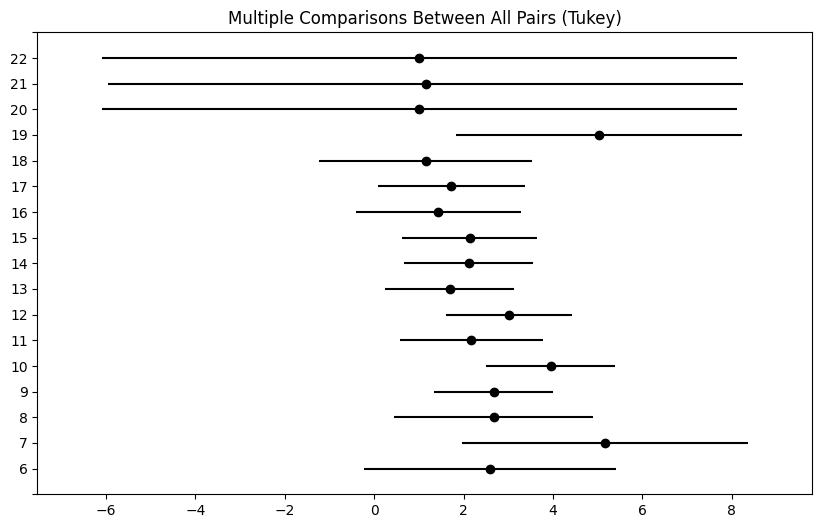

Hours with a significantly higher mean engagement rate than the other hours:
Empty DataFrame
Columns: [group1, group2, meandiff, p-adj, lower, upper, reject]
Index: []
Tuesday


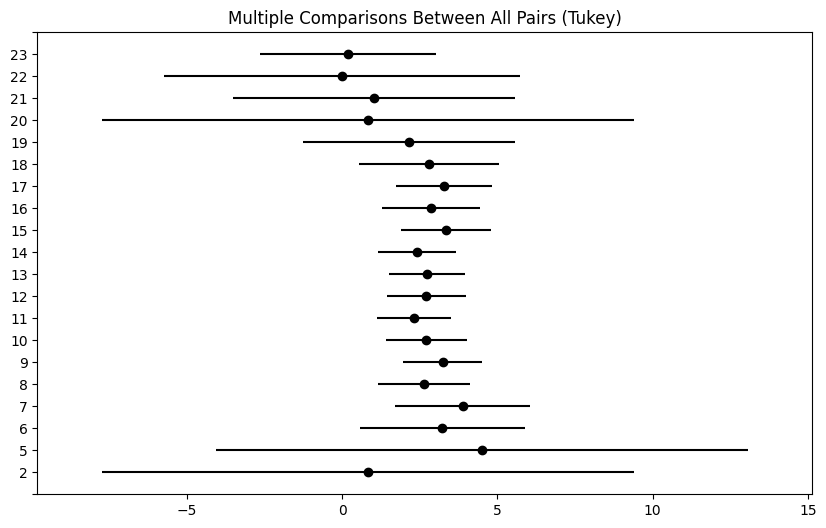

Hours with a significantly higher mean engagement rate than the other hours:
Empty DataFrame
Columns: [group1, group2, meandiff, p-adj, lower, upper, reject]
Index: []
Wednesday


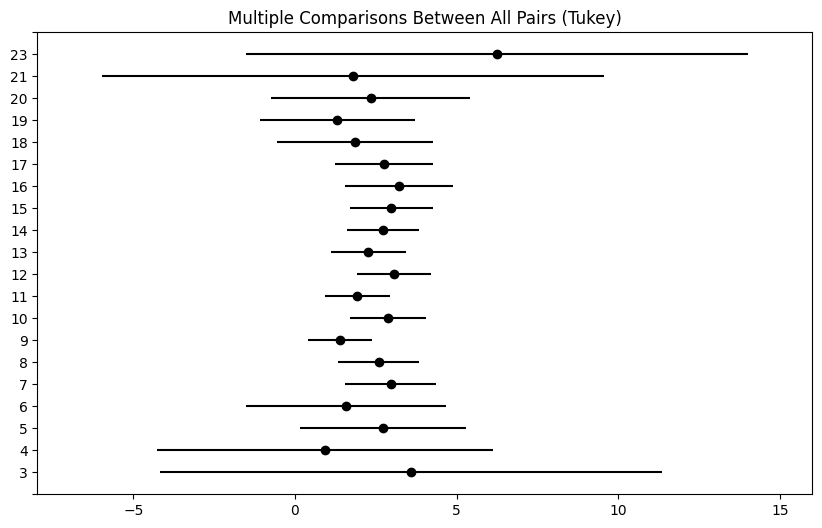

Hours with a significantly higher mean engagement rate than the other hours:
Empty DataFrame
Columns: [group1, group2, meandiff, p-adj, lower, upper, reject]
Index: []
Thursday


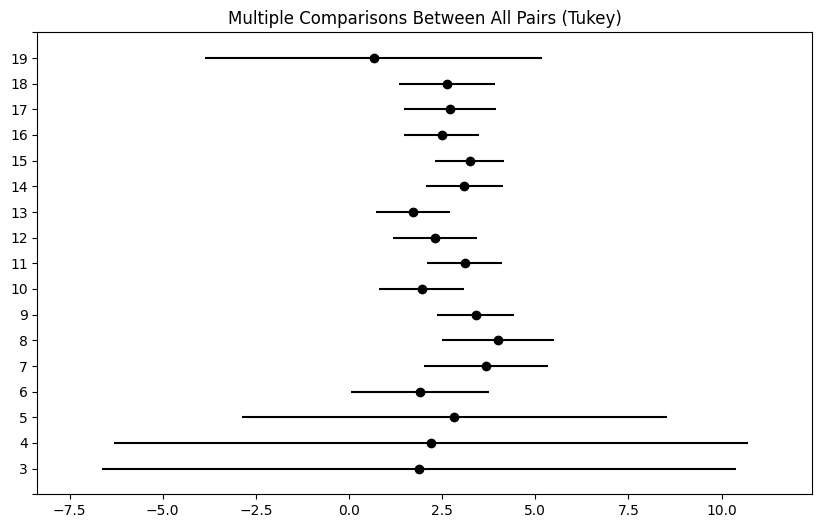

Hours with a significantly higher mean engagement rate than the other hours:
Empty DataFrame
Columns: [group1, group2, meandiff, p-adj, lower, upper, reject]
Index: []
Friday


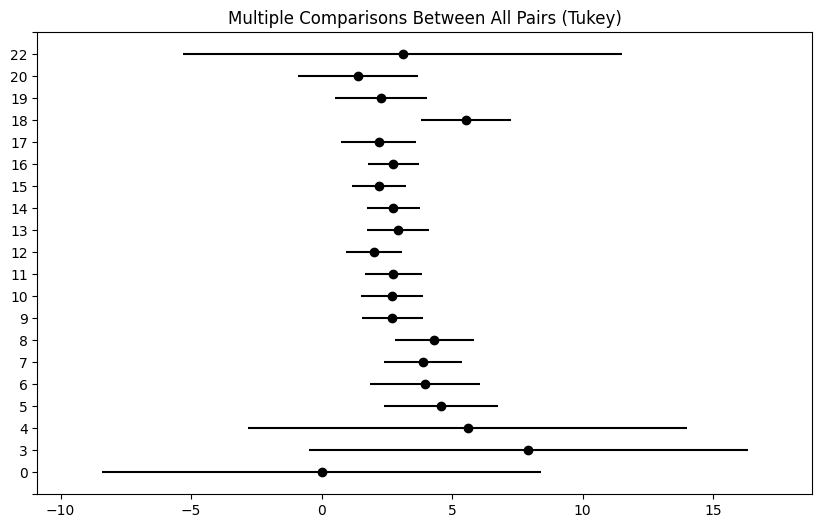

Hours with a significantly higher mean engagement rate than the other hours:
     group1  group2  meandiff   p-adj   lower   upper  reject
120       9      18    2.8207  0.0444  0.0290  5.6124    True
141      11      18    2.7781  0.0403  0.0507  5.5055    True
150      12      18    3.5244  0.0007  0.8311  6.2178    True
165      14      18    2.7751  0.0303  0.1131  5.4371    True
171      15      18    3.3374  0.0016  0.6754  5.9994    True
176      16      18    2.7901  0.0219  0.1795  5.4007    True
180      17      18    3.3472  0.0175  0.2651  6.4294    True
185      18      20   -4.1224  0.0344 -8.1174 -0.1275    True
Saturday


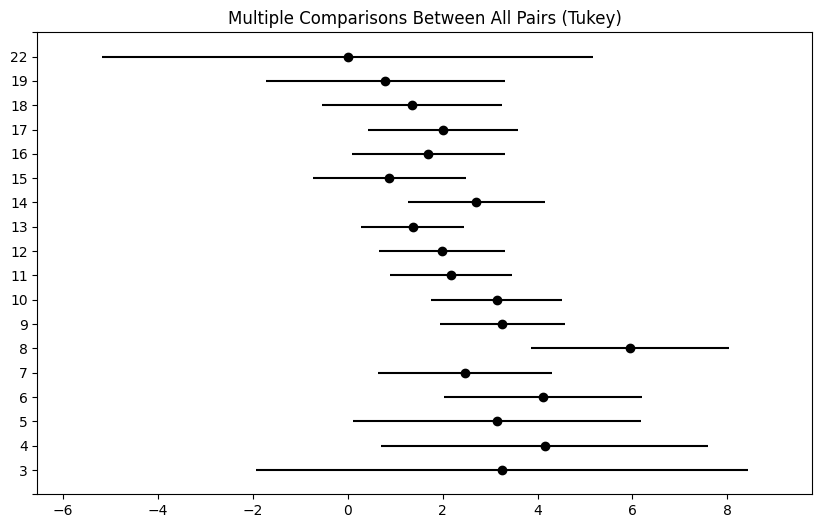

Hours with a significantly higher mean engagement rate than the other hours:
    group1  group2  meandiff   p-adj   lower   upper  reject
77       8      11   -3.7703  0.0135 -7.1650 -0.3756    True
78       8      12   -3.9681  0.0072 -7.3929 -0.5432    True
79       8      13   -4.5864  0.0001 -7.7870 -1.3859    True
81       8      15   -5.0791  0.0003 -8.7841 -1.3741    True
82       8      16   -4.2585  0.0082 -7.9635 -0.5535    True
83       8      17   -3.9426  0.0210 -7.6092 -0.2759    True
84       8      18   -4.6003  0.0075 -8.5810 -0.6197    True
85       8      19   -5.1606  0.0110 -9.7421 -0.5791    True
Sunday


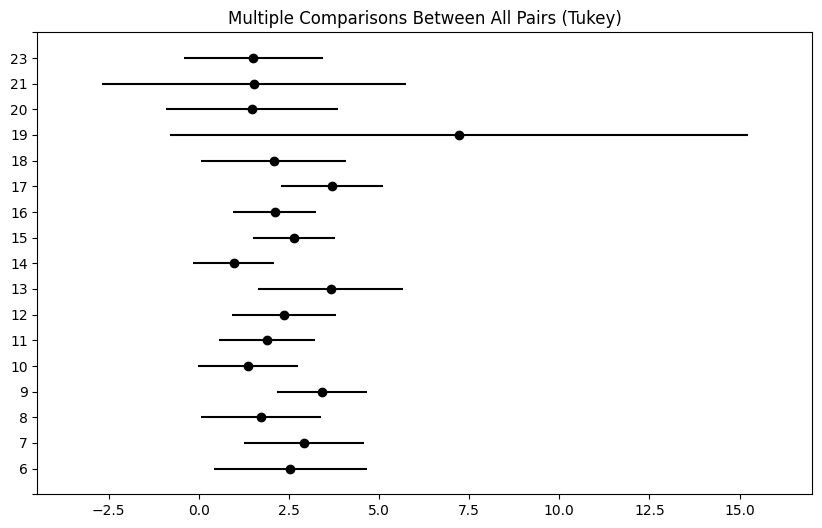

Hours with a significantly higher mean engagement rate than the other hours:
     group1  group2  meandiff  p-adj   lower   upper  reject
49        9      14   -2.4407  0.017 -4.6731 -0.2082    True
102      14      17    2.7268  0.013  0.2812  5.1724    True


In [292]:
# perform a statistical test to find out which hours of the day have a significantly higher mean engagement rate than the other hours
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

for day in days:
    print(day)
    # perform the statistical test
    tukey_result = pairwise_tukeyhsd(df[df[PUBLISHED_DATE].dt.weekday == days.index(day)][ENGAGEMENT_RATE], df[df[PUBLISHED_DATE].dt.weekday == days.index(day)][PUBLISHED_DATE].dt.hour, 0.05)

    # from the result of the test above, find out which hours of the day have a significantly higher mean engagement rate than the other hours
    tukey_result.plot_simultaneous()
    plt.show()

    print('Hours with a significantly higher mean engagement rate than the other hours:')
    # convert the result of the test to a dataframe
    tukey_result_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
    print(tukey_result_df[tukey_result_df['reject'] == True])

In [253]:
# plot a graph with multiple lines, one for each day of the week, showing the mean engagement rate for each hour of the day
fig = px.line(hour_day_df, x='Hour', y=ENGAGEMENT_RATE, color='Day')
fig.update_layout(title='Mean Engagement Rate by Hour of the Day', xaxis_title='Hour of the Day', yaxis_title='Mean Engagement Rate (%)', yaxis_range=[0, 10], xaxis_range=[0,24])
fig.show()

## Effect on engagement rate based on day and hour of posting on specific platforms

In [302]:
ACCOUNT_TYPE = 'Account Type'

# create a groupby object by grouping the data by account type
day_account_type_group = df.groupby([df[PUBLISHED_DATE].dt.weekday, df[ACCOUNT_TYPE]])

# create a new dataframe with the mean engagement rate for each hour of the day and account type and the number of posts
day_account_type_df = pd.DataFrame(day_account_type_group[ENGAGEMENT_RATE].mean())
day_account_type_df['Day'] = day_account_type_df.index.get_level_values(0)
day_account_type_df['Account Type'] = day_account_type_df.index.get_level_values(1)
day_account_type_df.reset_index(drop=True, inplace=True)

# sort the dataframe by hour of the day and account type
day_account_type_df.sort_values(['Day', 'Account Type'], inplace=True)

# add number of posts to the dataframe
day_account_type_df[NUMBER_OF_POSTS] = day_account_type_group[ENGAGEMENT_RATE].count().values

# plot bar graphs of the mean engagement rate for each hour of the day, one for each account type
account_types = df[ACCOUNT_TYPE].unique()

for account_type in account_types:
    fig = px.bar(day_account_type_df[day_account_type_df['Account Type'] == account_type], x='Day', y=ENGAGEMENT_RATE, color=NUMBER_OF_POSTS, color_continuous_scale=COLOR)
    fig.update_layout(title='Mean Engagement Rate per Day for {0} Accounts'.format(account_type), xaxis_title='Day of the Week', yaxis_title='Mean Engagement Rate (%)', yaxis_range=[0, 10], xaxis_range=[-1,7])
    fig.show()

In [280]:
# create a groupby object by grouping the data by account type
hour_account_type_group = df.groupby([df[PUBLISHED_DATE].dt.hour, df[ACCOUNT_TYPE]])

# create a new dataframe with the mean engagement rate for each hour of the day and account type and the number of posts
hour_account_type_df = pd.DataFrame(hour_account_type_group[ENGAGEMENT_RATE].mean())
hour_account_type_df['Hour'] = hour_account_type_df.index.get_level_values(0)
hour_account_type_df['Account Type'] = hour_account_type_df.index.get_level_values(1)
hour_account_type_df.reset_index(drop=True, inplace=True)

# sort the dataframe by hour of the day and account type
hour_account_type_df.sort_values(['Hour', 'Account Type'], inplace=True)

# add number of posts to the dataframe
hour_account_type_df[NUMBER_OF_POSTS] = hour_account_type_group[ENGAGEMENT_RATE].count().values

# plot bar graphs of the mean engagement rate for each hour of the day, one for each account type
account_types = df[ACCOUNT_TYPE].unique()

for account_type in account_types:
    fig = px.bar(hour_account_type_df[hour_account_type_df['Account Type'] == account_type], x='Hour', y=ENGAGEMENT_RATE, color=NUMBER_OF_POSTS, color_continuous_scale=COLOR)
    fig.update_layout(title='Mean Engagement Rate by Hour of the Day for {0} Accounts'.format(account_type), xaxis_title='Hour of the Day', yaxis_title='Mean Engagement Rate (%)', yaxis_range=[0, 10], xaxis_range=[0,24])
    fig.show()

# How are our game titles doing in terms of social performance? Is there a specific game we should focus more on or less?

In [254]:
# get all the unique values in the account column
accounts = df['Account'].unique()
accounts

array(['CSGO', 'DOTA2', 'General', 'Content Creators', 'Valorant'],
      dtype=object)

In [255]:
games = ['CSGO', 'DOTA2', 'Valorant']

# create a new dataframe with only the data for the games accounts
games_df = pd.DataFrame(df[df['Account'].isin(games)])
games_outliers = pd.DataFrame(outliers[outliers['Account'].isin(games)])

In [256]:
# create a groupby object by grouping the data by the 'Account' column
games_group = games_df.groupby('Account')
games_outliers_group = games_outliers.groupby('Account')

# create a new dataframe with the mean engagement rate for each game
games_mean_df = pd.DataFrame(games_group[ENGAGEMENT_RATE].mean())

In [257]:
# mean engagement rate for games
print('Mean engagement rate for games:{0:.2f}%'.format(games_mean_df[ENGAGEMENT_RATE].mean()))

Mean engagement rate for games:2.99%


In [258]:
games_mean_df

,Engagement Rate
Account,
CSGO,2.395898
DOTA2,3.728344
Valorant,2.833729


In [259]:
# create a bar chart of the mean engagement rate for each game
fig = px.bar(games_mean_df, x=games_mean_df.index, y=ENGAGEMENT_RATE, color=ENGAGEMENT_RATE, color_continuous_scale=COLOR)
fig.update_layout(title='Mean Engagement Rate by Game', xaxis_title='Game', yaxis_title='Mean Engagement Rate (%)')
fig.show()

In [260]:
# create a dataframe with the mean engagement rate and the number of posts for each game
games_df = pd.DataFrame(games_group[ENGAGEMENT_RATE].mean())
games_df[NUMBER_OF_POSTS] = games_group[ENGAGEMENT_RATE].count()
games_df[WEIGHTED_RATE] = games_df[ENGAGEMENT_RATE] / games_df[NUMBER_OF_POSTS]
games_df['Total Engagement'] = games_group['Total Engagements'].sum()
games_df['Engagement Per Post'] = games_df['Total Engagement'] / games_df[NUMBER_OF_POSTS]

# create a scatter plot of the number of posts vs engagement rate for each game
fig = px.scatter(games_df, x=NUMBER_OF_POSTS, y=ENGAGEMENT_RATE, color=games_df.index, hover_name=games_df.index, size=NUMBER_OF_POSTS, size_max=60)
fig.update_layout(title='Number of Posts vs Engagement Rate for Each Game', xaxis_title=NUMBER_OF_POSTS, yaxis_title='Mean Engagement Rate (%)')
fig.show()

In [295]:
# create a group by object by first grouping the data by the 'Account Type' and then by the 'Account' column
account_type_group = df.groupby(['Account', 'Account Type', 'Media Type'])

# create a new dataframe with the mean engagement rate for each account type and account and the number of posts for each account type and account
account_type_df = pd.DataFrame(account_type_group[ENGAGEMENT_RATE].mean())
account_type_df[NUMBER_OF_POSTS] = account_type_group[ENGAGEMENT_RATE].count()

# create a dataframe that only has the data for the games accounts
games_account_type_df = pd.DataFrame(account_type_df[account_type_df.index.get_level_values(0).isin(games)])

games_account_type_df

Engagement Rate  Number of Posts
Account  Account Type Media Type                                  
CSGO     TWITTER      Link               0.117500               20
                      Photo              2.202590              139
                      Text               1.502419               62
                      Video              6.048286               35
DOTA2    TWITTER      Link               2.647143                7
                      Photo              4.417469              320
                      Text               2.772663              338
                      Video              4.950106               94
         YOUTUBE      Video              3.131250                8
Valorant YOUTUBE      Link               0.000000                2
                      Text               0.000000               15
                      Video              3.980714               42

In [262]:
# flatten the multi-index dataframe
games_account_type_df = games_account_type_df.reset_index()

# for each game, create a bar chart of the mean engagement rate for each account type and media type
for game in games:
    fig = px.bar(games_account_type_df[games_account_type_df['Account'] == game], x='Account Type', y=ENGAGEMENT_RATE, color='Media Type', barmode='group')
    fig.update_layout(title='Mean Engagement Rate by Account Type and Media Type for {0}'.format(game), xaxis_title='Account Type', yaxis_title='Mean Engagement Rate (%)')
    fig.show()

## Analysis of Gaming accounts in comparison with Non Gaming accounts

In [296]:
# create a dataframe that only has the data for the non game accounts
non_games_account_type_df = pd.DataFrame(account_type_df[~account_type_df.index.get_level_values(0).isin(games)])

non_games_account_type_df

Engagement Rate  Number of Posts
Account          Account Type     Media Type                                  
Content Creators YOUTUBE          Link               0.000000                3
                                  Text               0.000000               12
                                  Video              3.444706               34
General          FBPAGE           Album              0.000000                3
                                  Link               0.057857               14
                                  Photo              5.046062              193
                                  Text               0.968649              111
                                  Video              6.095294               34
                 INSTAGRAM        Carousel           3.783333                9
                                  Link               0.000000                1
                                  Photo              0.414093              281
                                  Text               0.000000               96
                                  Video              1.141500              200
                 LINKEDIN_COMPANY Link               2.310000                3
                                  Photo              1.933846               13
                                  Text               0.612500                4
                                  Video              2.480000                2
                 TIKTOK_BUSINESS  Video              5.065273              110
                 TWITTER          Link               0.808537               41
                                  Mixed              6.796667                3
                                  Photo              1.537154              376
                                  Text               2.353231              229
                                  Video              3.304502              231
                 YOUTUBE          Text               0.000000               13
                                  Video              2.886163               86

In [303]:
account_type_df

Engagement Rate  Number of Posts
Account          Account Type     Media Type                                  
CSGO             TWITTER          Link               0.117500               20
                                  Photo              2.202590              139
                                  Text               1.502419               62
                                  Video              6.048286               35
Content Creators YOUTUBE          Link               0.000000                3
                                  Text               0.000000               12
                                  Video              3.444706               34
DOTA2            TWITTER          Link               2.647143                7
                                  Photo              4.417469              320
                                  Text               2.772663              338
                                  Video              4.950106               94
                 YOUTUBE          Video              3.131250                8
General          FBPAGE           Album              0.000000                3
                                  Link               0.057857               14
                                  Photo              5.046062              193
                                  Text               0.968649              111
                                  Video              6.095294               34
                 INSTAGRAM        Carousel           3.783333                9
                                  Link               0.000000                1
                                  Photo              0.414093              281
                                  Text               0.000000               96
                                  Video              1.141500              200
                 LINKEDIN_COMPANY Link               2.310000                3
                                  Photo              1.933846               13
                                  Text               0.612500                4
                                  Video              2.480000                2
                 TIKTOK_BUSINESS  Video              5.065273              110
                 TWITTER          Link               0.808537               41
                                  Mixed              6.796667                3
                                  Photo              1.537154              376
                                  Text               2.353231              229
                                  Video              3.304502              231
                 YOUTUBE          Text               0.000000               13
                                  Video              2.886163               86
Valorant         YOUTUBE          Link               0.000000                2
                                  Text               0.000000               15
                                  Video              3.980714               42

In [305]:
# create a pie chart of the number of posts for gaming and non gaming accounts
number_of_non_games_posts = non_games_account_type_df[NUMBER_OF_POSTS].sum()
number_of_games_posts = games_account_type_df[NUMBER_OF_POSTS].sum()

fig = px.pie(values=[number_of_non_games_posts, number_of_games_posts], names=['Non Games', 'Games'], title='Number of Posts for Gaming and Non Gaming Accounts')
fig.show()

# What media type performs the best?

In [263]:
# create a groupby object by grouping the data by Media Type
media_group = df.groupby('Media Type')

# create a new dataframe with the mean engagement rate for each media type and the number of posts for each media type
media_df = pd.DataFrame(media_group[ENGAGEMENT_RATE].mean())
media_df[NUMBER_OF_POSTS] = media_group[ENGAGEMENT_RATE].count()

In [264]:
# create a bar chart of the mean engagement rate for each media type
fig = px.bar(media_df, x=media_df.index, y=ENGAGEMENT_RATE, color=NUMBER_OF_POSTS, color_continuous_scale=COLOR)
fig.update_layout(title='Mean Engagement Rate by Media Type (Typical Posts)', xaxis_title='Media Type', yaxis_title='Mean Engagement Rate (%)')
fig.show()

In [265]:
# create a groupby object by grouping the data by Media Type
media_group = df_all.groupby('Media Type')

# create a new dataframe with the mean engagement rate for each media type and the number of posts for each media type
media_df = pd.DataFrame(media_group[ENGAGEMENT_RATE].mean())
media_df[NUMBER_OF_POSTS] = media_group[ENGAGEMENT_RATE].count()

# create a bar chart of the mean engagement rate for each media type
fig = px.bar(media_df, x=media_df.index, y=ENGAGEMENT_RATE, color=NUMBER_OF_POSTS, color_continuous_scale=COLOR)
fig.update_layout(title='Mean Engagement Rate by Media Type (All Posts)', xaxis_title='Media Type', yaxis_title='Mean Engagement Rate (%)')
fig.show()

In [266]:
# Number of outliers per media type
media_outliers = pd.DataFrame(outliers.groupby('Media Type')['Engagement Rate'].mean())
media_outliers['Number of Outliers'] = outliers.groupby('Media Type')['Engagement Rate'].count()

# create a pie chart of the number of posts for each media type with colors based on engagement rate
fig = px.pie(media_outliers, values='Number of Outliers', names=media_outliers.index, color='Engagement Rate')
fig.update_layout(title='Number of Outliers per Media Type')
fig.show()

# What is our best performing campaign?

In [267]:
# get the list of unique values in the Campaign Name column
campaigns = df_all['Campaign Name'].unique()
campaigns = [campaign for campaign in campaigns if str(campaign) != 'N/A']

# create a new dataframe with only the data for the campaigns
campaigns_df = pd.DataFrame(df_all[df_all['Campaign Name'].isin(campaigns)])

In [268]:
# create a groupby object by grouping the data by the 'Campaign Name' column
campaigns_group = campaigns_df.groupby('Campaign Name')

# create a new dataframe with the mean engagement rate for each campaign and the number of posts for each campaign
campaigns_df = pd.DataFrame(campaigns_group[ENGAGEMENT_RATE].mean())
campaigns_df[NUMBER_OF_POSTS] = campaigns_group[ENGAGEMENT_RATE].count()

In [269]:
# create a bar chart of the mean engagement rate for each campaign
fig = px.bar(campaigns_df, x=campaigns_df.index, y=ENGAGEMENT_RATE, color=NUMBER_OF_POSTS, color_continuous_scale=COLOR)
fig.update_layout(title='Mean Engagement Rate by Campaign', xaxis_title='Campaign', yaxis_title='Mean Engagement Rate (%)')
fig.show()

In [270]:
# find the number of outliers for each campaign
campaigns_outliers_group = outliers.groupby('Campaign Name')
campaigns_outliers_df = pd.DataFrame(campaigns_outliers_group['Engagement Rate'].mean())
campaigns_outliers_df['Number of Outliers'] = campaigns_outliers_group['Engagement Rate'].count()

# create a pie chart of the number of posts for each campaign with colors based on engagement rate
fig = px.pie(campaigns_outliers_df, values='Number of Outliers', names=campaigns_outliers_df.index, color='Engagement Rate')
fig.update_layout(title='Number of Outliers per Campaign')
fig.show()